I will be exploring two datasets for bias: Adult dataset and Student Performance dataset.

I will will be performing very similar tasks with both datasets. 
The reason why I decided to perform this assignment "twice" is becuase every dataset is unique and I wanted more exposure to handleling data for different tasks.

Adult dataset:
Starting with the adult dataset, I wanted to practice downloading the data manually rather than using the import from the ucimlrepo. I manually set the column names, categorical and numerical variables using the information from the website.

A lot of the features are self explanatory. Here are some of the definitons of the variables that are not so explicit.

fnlwgt: This stands for "final weight", since the census actually represents the entire population. This value is supossed to represent how many individuals the census thinks this person represents.

capital-gain: capital gains for an individual.

capital-loss: capital loss for an individual.

In [57]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error,r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, compute_sample_weight
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import dice_ml
import lime
import lime.lime_tabular


from aif360.datasets import StructuredDataset, BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

sys.path.append("../")

   age          workclass  fnlwgt   education  education-num  \
0   50   Self-emp-not-inc   83311   Bachelors             13   
1   38            Private  215646     HS-grad              9   
2   53            Private  234721        11th              7   
3   28            Private  338409   Bachelors             13   
4   37            Private  284582     Masters             14   

        marital-status          occupation    relationship    race      sex  \
0   Married-civ-spouse     Exec-managerial         Husband   White     Male   
1             Divorced   Handlers-cleaners   Not-in-family   White     Male   
2   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
3   Married-civ-spouse      Prof-specialty            Wife   Black   Female   
4   Married-civ-spouse     Exec-managerial            Wife   White   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0             0             0              13   United-States   <=50

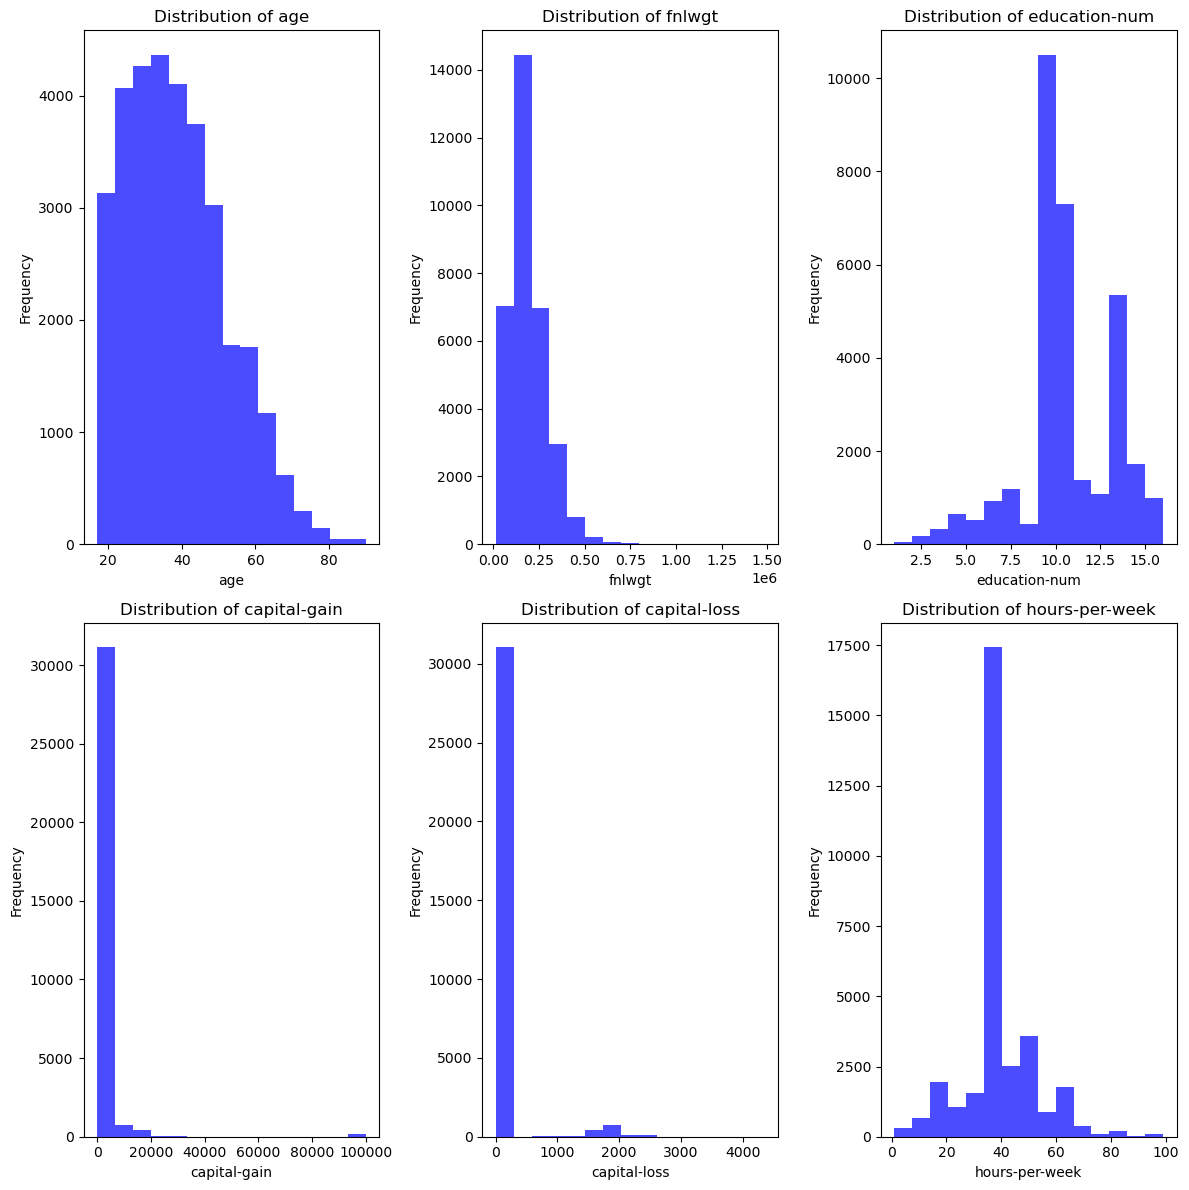

C:\Users\ramosv\AppData\Local\Temp\ipykernel_9844\3795040815.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_9844\3795040815.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_9844\3795040815.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_9844\3795040815.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_9844\3795040815.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.a

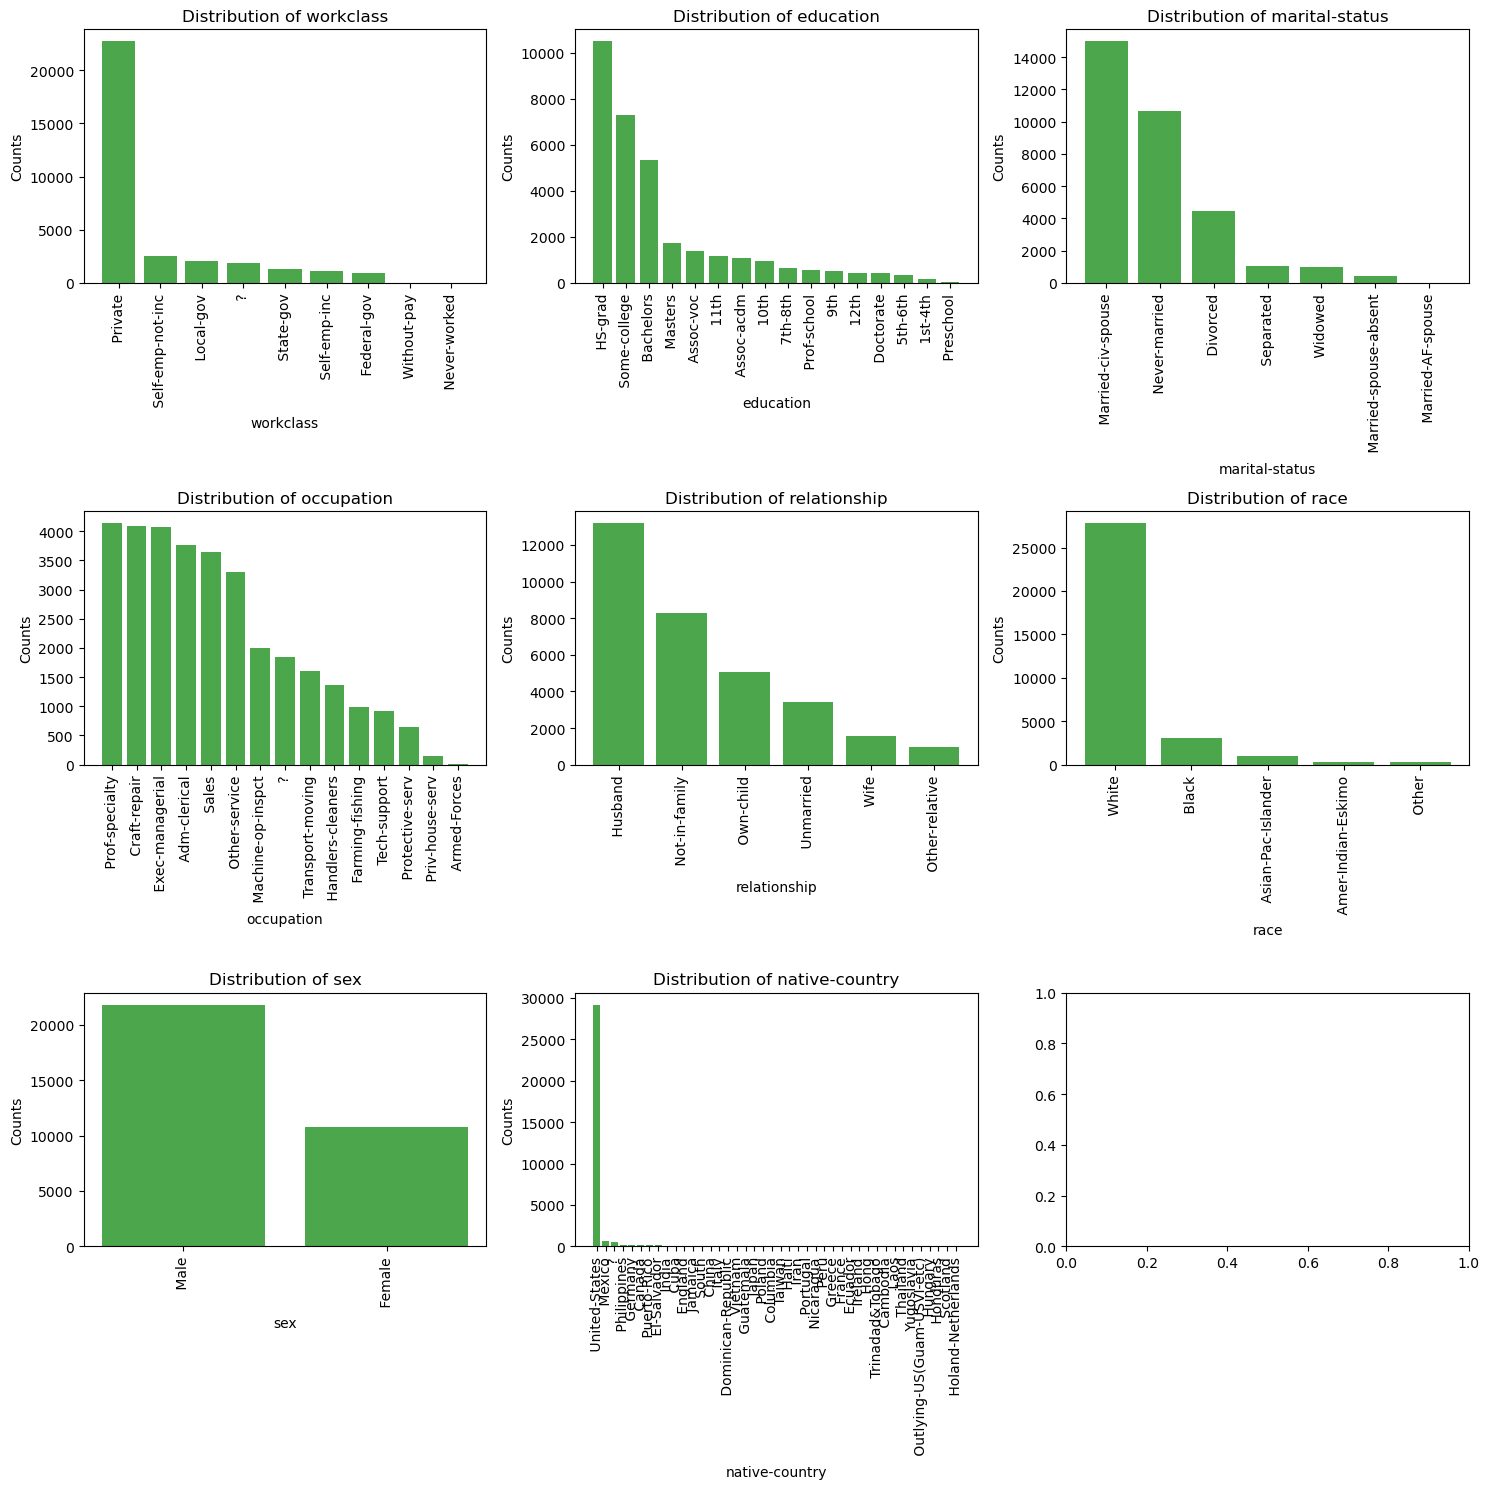

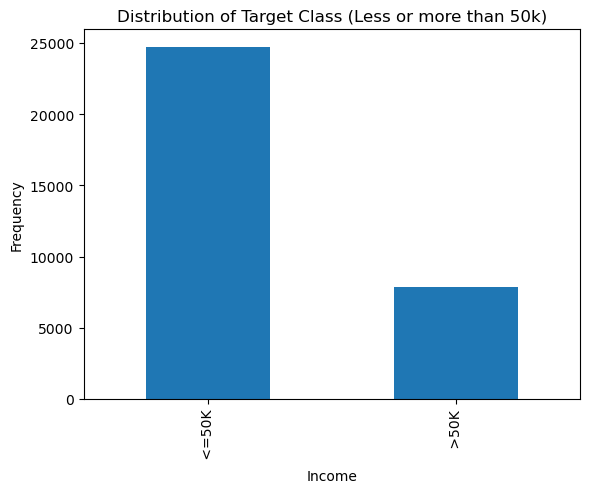

In [2]:
adult_data = pd.read_csv("C:/Users/ramosv/Desktop/GitHub/Removing-Bias-from-ML-Models/adult/adult.data")
adult_test = pd.read_csv("C:/Users/ramosv/Desktop/GitHub/Removing-Bias-from-ML-Models/adult/adult.test")

# columns_names = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]

# adult_data.columns = columns_names
# adult_test.columns = columns_names

# adult_data_combined = adult_data.append(adult_test, ignore_index=True)

columns_names = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]

categorical_variables = ["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]
numerical_variables = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
target = "income"

adult_data.columns = columns_names

# Exploring some basic statistics about the dataset
print(adult_data.head())
print(adult_data.info())
print(adult_data.isnull().sum())

# Lets explore the distribution of the numerical variables
figures, axes = plt.subplots(2,3, figsize=(12,12))

for axis, var in zip(axes.flatten(), numerical_variables):
    axis.hist(adult_data[var], bins=15, color="blue", alpha=0.7)
    axis.set_title(f"Distribution of {var}")
    axis.set_xlabel(var)
    axis.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Now for the categorical variables
figures, axes = plt.subplots(3,3, figsize=(15,15))

for column in categorical_variables:
    adult_data[column] = adult_data[f"{column}"].astype("category")

for axis, var in zip(axes.flatten(), categorical_variables):
    counts = adult_data[var].value_counts().sort_values(ascending=False)
    bars = axis.bar(counts.index.astype(str), counts.values, color='green', alpha=0.7)
    axis.set_title(f'Distribution of {var}')
    axis.set_xlabel(var)
    axis.set_ylabel('Counts')
    axis.set_xticklabels(counts.index.astype(str), rotation=90)

plt.tight_layout()
plt.show()

#Lastly we will analize the distrubtion of the target class. This is the class that the model will try to predict.

adult_data['income'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Class (Less or more than 50k)')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()


Lets review our findings:

Here is dominating value for each feature in our dateset:

age = Between 30 and 40 years old
"workclass" = Private
"fnlwgt" = Between 0.0 and 0.2
"education" = High school graduate
"education-num" = 9 which represents high school graduates
"marital-status" = Married Civil Spouse
"occupation" = Prof-Speciality
"relationship" = Husband
"race" = White
"sex" = Male
"capital-gain" = 0
"capital-loss" = 0
"hours-per-week" = 40
"native-country" = United States
"income" = <=50k

By looking at the dominating values for each feature as well as the distrubution of these values. We can begin to look at certain features that the model could use for Bias.

The education and education-num can be commbined into a single feature since they refer to the same thing.

Additonaly findings:
Age, Education and Workclass

Here are the next steps in this assignment:

- I will begin by constructing a random forest model to use as a baseline.
- Next, I will investigate the original dataset for any Bias using Statistical Parity Difference and Disparitive Impact
- Next, I will attempt to mitigate this bias and re-train the model.
- Lastly, I will compare the two models pre/post bias too see which model performed best.

In [5]:
#I will first load the data into a dataframe again. (I am doing this again since I had to modify the data for the plots)
#The data was previously split in the following way:
#45222 if instances with unknown values are removed (train=30162, test=15060)

adult_income_data = pd.read_csv("C:/Users/ramosv/Desktop/GitHub/Removing-Bias-from-ML-Models/adult/adult.data")
adult_income_test = pd.read_csv("C:/Users/ramosv/Desktop/GitHub/Removing-Bias-from-ML-Models/adult/adult.test")

columns_names = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]

adult_income_data.columns = columns_names
adult_income_test.columns = columns_names

#By looking at the data I found a few instnces of the value "?"
#We will replace by a nan and then drop those

adult_income_data.replace(' ?', pd.NA, inplace=True)
adult_income_test.replace(' ?', pd.NA, inplace=True)

adult_income_data.dropna(inplace=True)
adult_income_test.dropna(inplace=True)


#39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
#25, Private, 226802, 11th, 7, Never-married, Machine-op-inspct, Own-child, Black, Male, 0, 0, 40, United-States, <=50K.

# Ive decicded to drop the fnlwgt, capital-gain and capital-loss column since it does not provide any valuable information in my opinion
adult_income_data.drop(["fnlwgt","capital-gain","capital-loss"], axis=1, inplace=True)
adult_income_test.drop(["fnlwgt","capital-gain","capital-loss"], axis=1, inplace=True)

# I was able to find why my model was performing so poorly at first
# The test dataset provided added a period (".") at the end of the target variable
#print(adult_income_data['income'].unique())
#print(adult_income_test['income'].unique())

#OUTPUT for line above
# [' <=50K' ' >50K']
# [' <=50K.' ' >50K.']

#print(adult_income_data)
#print(adult_income_test)

adult_income_data['income'] = adult_income_data['income'].str.strip().replace("\\.", "", regex=True)
adult_income_test['income'] = adult_income_test['income'].str.strip().replace("\\.", "", regex=True)

label_encoder = LabelEncoder()
adult_income_data['target_binary'] = label_encoder.fit_transform(adult_income_data['income'])
adult_income_test['target_binary'] = label_encoder.transform(adult_income_test['income'])

#print(adult_income_data)
#print(adult_income_test)

categorical_variables = ["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]
numerical_variables = ["age","education-num","hours-per-week"]
# I will be using ColumnTransformer and Pipeline from skcit learn. I became more comfortable working with these components during assignemtn 1
process = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_variables), ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_variables)])

# Now we pass the ColumnTransformer variable to the Pipeline
model = Pipeline(steps=[('preprocessor', process),('classifier', RandomForestClassifier(random_state=42))])

# Seetting up our features and target varaibles manually since the data was already split
X_train = adult_income_data.drop(["income","target_binary"], axis=1)
X_test = adult_income_test.drop(["income","target_binary"], axis=1)
y_train = adult_income_data["target_binary"]
y_test = adult_income_test["target_binary"]

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.86      0.89      0.88     11359
           1       0.63      0.55      0.59      3700

    accuracy                           0.81     15059
   macro avg       0.74      0.72      0.73     15059
weighted avg       0.80      0.81      0.81     15059



Figuring out feature importance.
I am aware that I could have combined the two datasets sets. Data and test to make easier on myself. But this is the first time I've worked with a dataset that was already split and I thought it would be interesteing to proceed like this.

age: 0.2823
hours-per-week: 0.1391
education-num: 0.0787
marital-status_ Married-civ-spouse: 0.0758
relationship_ Husband: 0.0534
marital-status_ Never-married: 0.0268
occupation_ Exec-managerial: 0.0226
occupation_ Prof-specialty: 0.0188
workclass_ Private: 0.0131
education_ Bachelors: 0.0127
sex_ Female: 0.0115
relationship_ Wife: 0.0114
relationship_ Not-in-family: 0.0111
workclass_ Self-emp-not-inc: 0.0104
education_ Masters: 0.0095
sex_ Male: 0.0095
occupation_ Other-service: 0.0094
occupation_ Sales: 0.0087
occupation_ Craft-repair: 0.0087
relationship_ Own-child: 0.0082
education_ HS-grad: 0.0082
race_ White: 0.0079
workclass_ Self-emp-inc: 0.0078
marital-status_ Divorced: 0.0075
workclass_ Local-gov: 0.0075
occupation_ Adm-clerical: 0.0072
native-country_ United-States: 0.0070
education_ Some-college: 0.0066
race_ Black: 0.0064
education_ Prof-school: 0.0062
workclass_ Federal-gov: 0.0062
workclass_ State-gov: 0.0061
occupation_ Farming-fishing: 0.0059
occupation_ Tech-support:

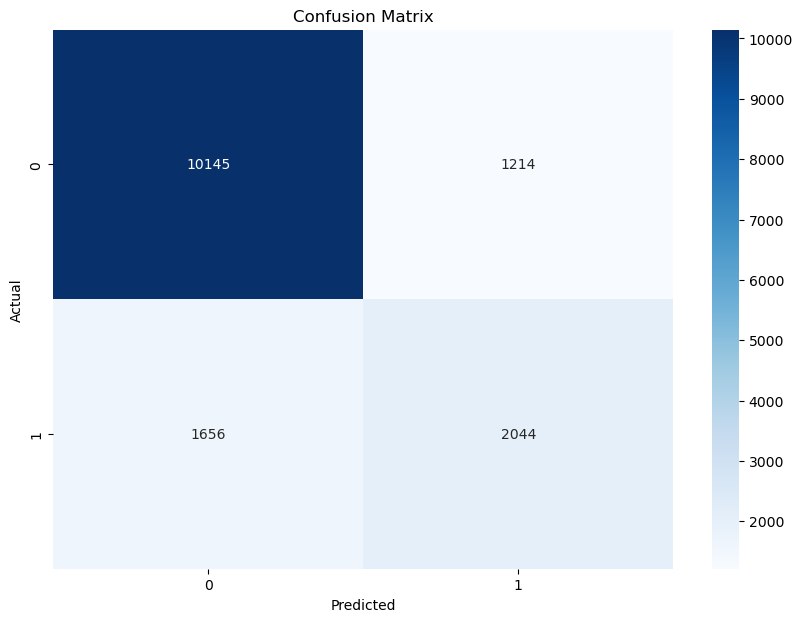

Correlation Matrix:
                     age  education-num  hours-per-week  target_binary
age             1.000000       0.043525        0.101599       0.242000
education-num   0.043525       1.000000        0.152528       0.335317
hours-per-week  0.101599       0.152528        1.000000       0.229480
target_binary   0.242000       0.335317        0.229480       1.000000


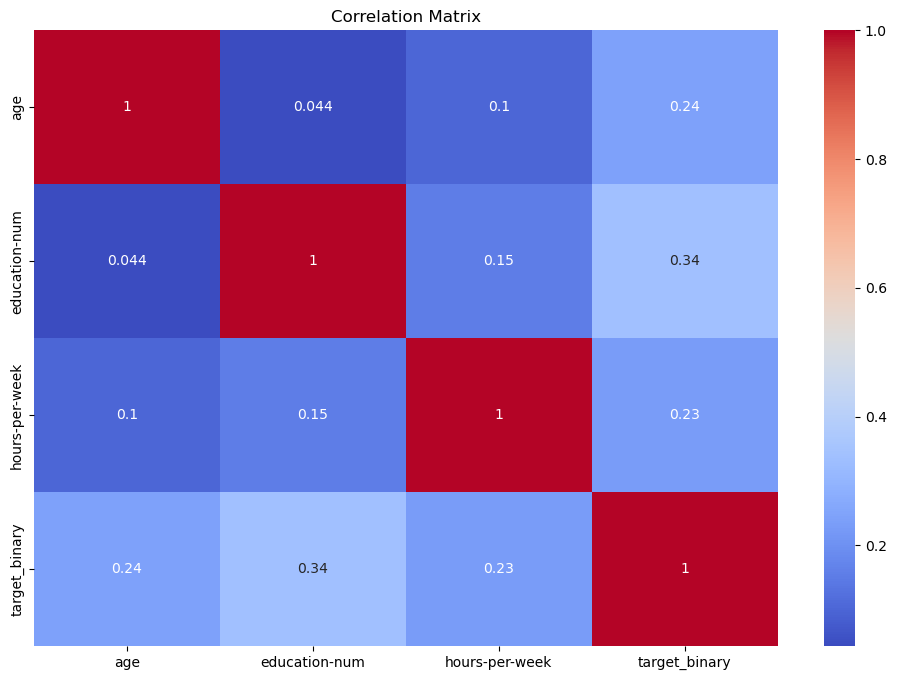

In [6]:

#I resused a lot of the code for figure out features importance from assignemnt 1
#I left some of the comments that I wrote for myself since they help me better understand the code

# Creating a variable for the model we built ealier.
# Since we used the pipeline function it needs to be accesed using the named_steps property
rf_classifier = model.named_steps['classifier']

# Using the feature_importances_ attribute of our model: RandomForestClassifier. Documentation for this is highlated above
importances = rf_classifier.feature_importances_
#print(importances)

# Again using the named_steps property to access the preprocessor.
preprocessor = model.named_steps['preprocessor']

# Now we can use the preprocessor to get column/feature names from categorical features. These need to be accesed through the preprocessor
# We use .named_transformers_['cat'] to pull the categories from our transformer "onehotencoder" used earlier
category_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
#print(category_features)

#Geting all of the features names in sinve variable called
feature_names = np.concatenate([numerical_variables, category_features])
#print(feature_names)

# Now we combine both the names and the importances.
feature_importances = np.array([feature_names, importances])
#print(feature_importances)

# Sorting the features by their importance
# Sort in decensing order.
sorted_indices = np.argsort(importances)[::-1]
sorted_features = []

# Now we will combine the feature along with the level of importance
for idx in sorted_indices:
    feature = feature_names[idx]
    num = importances[idx]
    sorted_features.append((feature, float(num)))

#Printing the featues and their importance!
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Correlation Matrix for training data
correlation_matrix = adult_income_data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()




From figuring out Feature importance I seems that age is the biggest contributor for idendifying the target class.

I few other points that I noticed from the model perfoamnce results

The model does farely well at predicting when an individual makes less than 50k a year. But it struggles more with predicting for people when they make more than 50k a year.

Thi due to the fact that our target class is heavily imbalanced.

              precision    recall  f1-score   support

           0       0.86      0.89      0.88     11359
           1       0.63      0.55      0.59      3700

    accuracy                           0.81     15059
   macro avg       0.74      0.72      0.73     15059
weighted avg       0.80      0.81      0.81     15059


I have a suspiccion that the model is predicting older individuals to be more likely to have larger income

In [10]:
#Lets merge the two data sets first:
adult_data_combined = adult_income_data.append(adult_income_test, ignore_index=True)

#Well have to drop the income column since LabelEncoder() wont be able to turn <=50 and >50 to numbers
#This is okay since we already have ["target_binary"] column which represents the same data

adult_data_combined.drop(columns=['income'], inplace=True)

#I will need to encode all of my categorical data since the StandardDateset expect that
encoder = LabelEncoder()
for column in categorical_variables:
    adult_data_combined[column] = encoder.fit_transform(adult_data_combined[column])


def categorize_age(row):
    if row['age'] >= 40:
        return 1
    else:
        return 0

# Createing a new column and use the function above to apply this categorization to
adult_data_combined['Age_Binary'] = adult_data_combined.apply(categorize_age, axis=1)

# 0 being <=50k and 1 being >50k
dataset = StandardDataset(adult_data_combined,
                          label_name='target_binary',
                          favorable_classes=[1],
                          protected_attribute_names=['Age_Binary'],
                          privileged_classes=[[1]])

metric = BinaryLabelDatasetMetric(dataset,
                                  unprivileged_groups=[{'Age_Binary': 0}],
                                  privileged_groups=[{'Age_Binary': 1}])

# Calculating the Statistical Parity Difference for Age
spd = metric.statistical_parity_difference()
print("Statistical Parity Difference (SPD):", spd)

# Calculating and the Disparate Impact for Age
di = metric.disparate_impact()
print("Disparate Impact (DI):", di)




C:\Users\ramosv\AppData\Local\Temp\ipykernel_20300\2445232173.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adult_data_combined = adult_income_data.append(adult_income_test, ignore_index=True)


Statistical Parity Difference (SPD): -0.19850036772441879
Disparate Impact (DI): 0.44764993870813674


At the time of this progress report, I have finalized my findings on the adult dataset. I plan on implementing DiCE to reduce the model’s dependency on the “age” feature. My goal is to finalize all of my findings and conclusions by end of this week, Sunday July 14th. This leaves me with two weeks to tackle the academic performance dataset, which aims to predict the performance of high school students. I feel quite confident in my ability to review, analyze, identify and remove the bias from the academic performance dataset. This is especially true after successfully completing the review, analysis, and identification component on the adult dataset.

In [11]:
# Now to create some counterfactuals to see how we can modfiy the data to change the prediction
# I was able to refactor most of the code from one of the assgingments
preprocessor = model.named_steps['preprocessor']

all_features_transformed = numerical_variables + list(preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_variables))

X_train_transformed = pd.DataFrame(preprocessor.transform(X_train).toarray(), columns=all_features_transformed)
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test).toarray(), columns=all_features_transformed)

data_for_dice = pd.concat([X_train_transformed, y_train.reset_index(drop=True)], axis=1)

d = dice_ml.Data(dataframe=data_for_dice, continuous_features=numerical_variables, outcome_name='target_binary')
ml_model = dice_ml.Model(model=model.named_steps['classifier'], backend='sklearn')

exp = dice_ml.Dice(d, ml_model)

test_instance = pd.DataFrame(X_test_transformed.iloc[0]).T
counterfactuals = exp.generate_counterfactuals(test_instance, total_CFs=5, desired_class="opposite")

print(counterfactuals.visualize_as_dataframe())


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C

Query instance (original outcome : 0)


,age,education-num,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,target_binary
0,-0.033338,-0.439703,0.75699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0



Diverse Counterfactual set (new outcome: 1)


,age,education-num,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,target_binary
0,-0.033338,-0.439703,0.75699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,-0.033338,2.081301,0.75699,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,-0.033338,-0.439703,0.75699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,-0.033338,2.081301,0.75699,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,-0.033338,-0.439703,0.75699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


None


From the counter facutals we see that there is not a lot of change for some features. This is a good indecator that the model bases most of its predictions based some primary features.

Lets continue to investigate age and see if we can adjust the distribution to be more evenly distributed rather than skeweed.

For this I will use the reweights preprocessing technique to see if we can fix the bias.

In [54]:
# I will be reusing most of the code from the previous cell so i removed the comments

adult_income_data = pd.read_csv("C:/Users/ramosv/Desktop/GitHub/Removing-Bias-from-ML-Models/adult/adult.data")
adult_income_test = pd.read_csv("C:/Users/ramosv/Desktop/GitHub/Removing-Bias-from-ML-Models/adult/adult.test")

columns_names = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]

adult_income_data.columns = columns_names
adult_income_test.columns = columns_names

adult_income_data.replace(' ?', pd.NA, inplace=True)
adult_income_test.replace(' ?', pd.NA, inplace=True)

adult_income_data.dropna(inplace=True)
adult_income_test.dropna(inplace=True)

adult_income_data.drop(["fnlwgt","capital-gain","capital-loss"], axis=1, inplace=True)
adult_income_test.drop(["fnlwgt","capital-gain","capital-loss"], axis=1, inplace=True)

adult_income_data['income'] = adult_income_data['income'].str.strip().replace("\\.", "", regex=True)
adult_income_test['income'] = adult_income_test['income'].str.strip().replace("\\.", "", regex=True)

label_encoder = LabelEncoder()
adult_income_data['target_binary'] = label_encoder.fit_transform(adult_income_data['income'])
adult_income_test['target_binary'] = label_encoder.transform(adult_income_test['income'])

categorical_variables = ["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]
numerical_variables = ["age","education-num","hours-per-week"]

# Ecoding of categorical variables so we can use them in the model and the reweighing part as well
encoder = LabelEncoder()
for column in categorical_variables:
    adult_income_data[column] = encoder.fit_transform(adult_income_data[column])
    adult_income_test[column] = encoder.transform(adult_income_test[column])

X_train = adult_income_data.drop(["income","target_binary"], axis=1)
X_test = adult_income_test.drop(["income","target_binary"], axis=1)
y_train = adult_income_data["target_binary"]
y_test = adult_income_test["target_binary"]


# Combine the training data for reweighting
train_data_combined = pd.concat([X_train, y_train], axis=1)

# Categorizing the age column into binary
def categorize_age(row):
    if row['age'] >= 40:
        return 1
    else:
        return 0

# Apply the function to the data
train_data_combined['Age_Binary'] = train_data_combined.apply(categorize_age, axis=1)

# Now we create a StandardDataset object using the new column
dataset_train = StandardDataset(train_data_combined,
                                label_name='target_binary',
                                favorable_classes=[1],
                                protected_attribute_names=['Age_Binary'],
                                privileged_classes=[[1]])

# Reweighing the dataset using the Reweighing class from AIF360
# all we need to do is pass the privileged and unprivileged groups as we have done in other using other AIF360 functions
RW = Reweighing(unprivileged_groups=[{'Age_Binary': 0}], privileged_groups=[{'Age_Binary': 1}])
dataset_transf_train = RW.fit_transform(dataset_train)

# Create sample weights to be used in training
sample_weights = dataset_transf_train.instance_weights

# From here we do we same as earlier
process = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_variables), ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_variables)])
model = Pipeline(steps=[('preprocessor', process), ('classifier', RandomForestClassifier(random_state=42))])

model.fit(X_train, y_train, classifier__sample_weight=sample_weights)
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11359
           1       0.62      0.55      0.58      3700

    accuracy                           0.81     15059
   macro avg       0.74      0.72      0.73     15059
weighted avg       0.80      0.81      0.80     15059



In [60]:
# Now we can check the bias of the rewighted dataset

# First ill combine create a copy of the test data and add the predictions to it
test_data_with_preds = X_test.copy()
test_data_with_preds['target_binary'] = y_test
test_data_with_preds['predictions'] = y_pred

# Then we create a new column for the binary age, and apply the same function from ealier to the data
test_data_with_preds['Age_Binary'] = test_data_with_preds.apply(categorize_age, axis=1)

#Using binary label dataset to calculate the metrics
dataset_test_with_preds = BinaryLabelDataset(df=test_data_with_preds,
                                             label_names=['target_binary'],
                                             protected_attribute_names=['Age_Binary'])

# Calculating the metrics
metric_test = BinaryLabelDatasetMetric(dataset_test_with_preds,
                                       unprivileged_groups=[{'Age_Binary': 0}],
                                       privileged_groups=[{'Age_Binary': 1}])

# FINALLY we can calculate the SpD and DI for Age
spd_test = metric_test.statistical_parity_difference()
print("Statistical Parity Difference (SPD):", spd_test)

di_test = metric_test.disparate_impact()
print("Disparate Impact (DI):", di_test)

Statistical Parity Difference (SPD): -0.1927163564817776
Disparate Impact (DI): 0.4545856373389283


Results and final thoughts

New  model perfomance after applying reweights:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11359
           1       0.62      0.55      0.58      3700

    accuracy                           0.81     15059
   macro avg       0.74      0.72      0.73     15059
weighted avg       0.80      0.81      0.80     15059

Bias with up reweights :

Statistical Parity Difference (SPD) on Test Data: -0.1927163564817776
Disparate Impact (DI) on Test Data: 0.4545856373389283

old performance without sampling:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     11359
           1       0.63      0.55      0.59      3700

    accuracy                           0.81     15059
   macro avg       0.74      0.72      0.73     15059
weighted avg       0.80      0.81      0.81     15059

Old bias without reweights:
Statistical Parity Difference (SPD): -0.19850036772441879
Disparate Impact (DI): 0.44764993870813674


This indicates that while reweighting helps in making the model fairer, it might come with a slight performance trade-off. Future steps could include exploring other bias mitigation techniques, such as adversarial debiasing or fairness-aware hyperparameter tuning, to further reduce bias while maintaining or improving model performance.


# Second Dataset

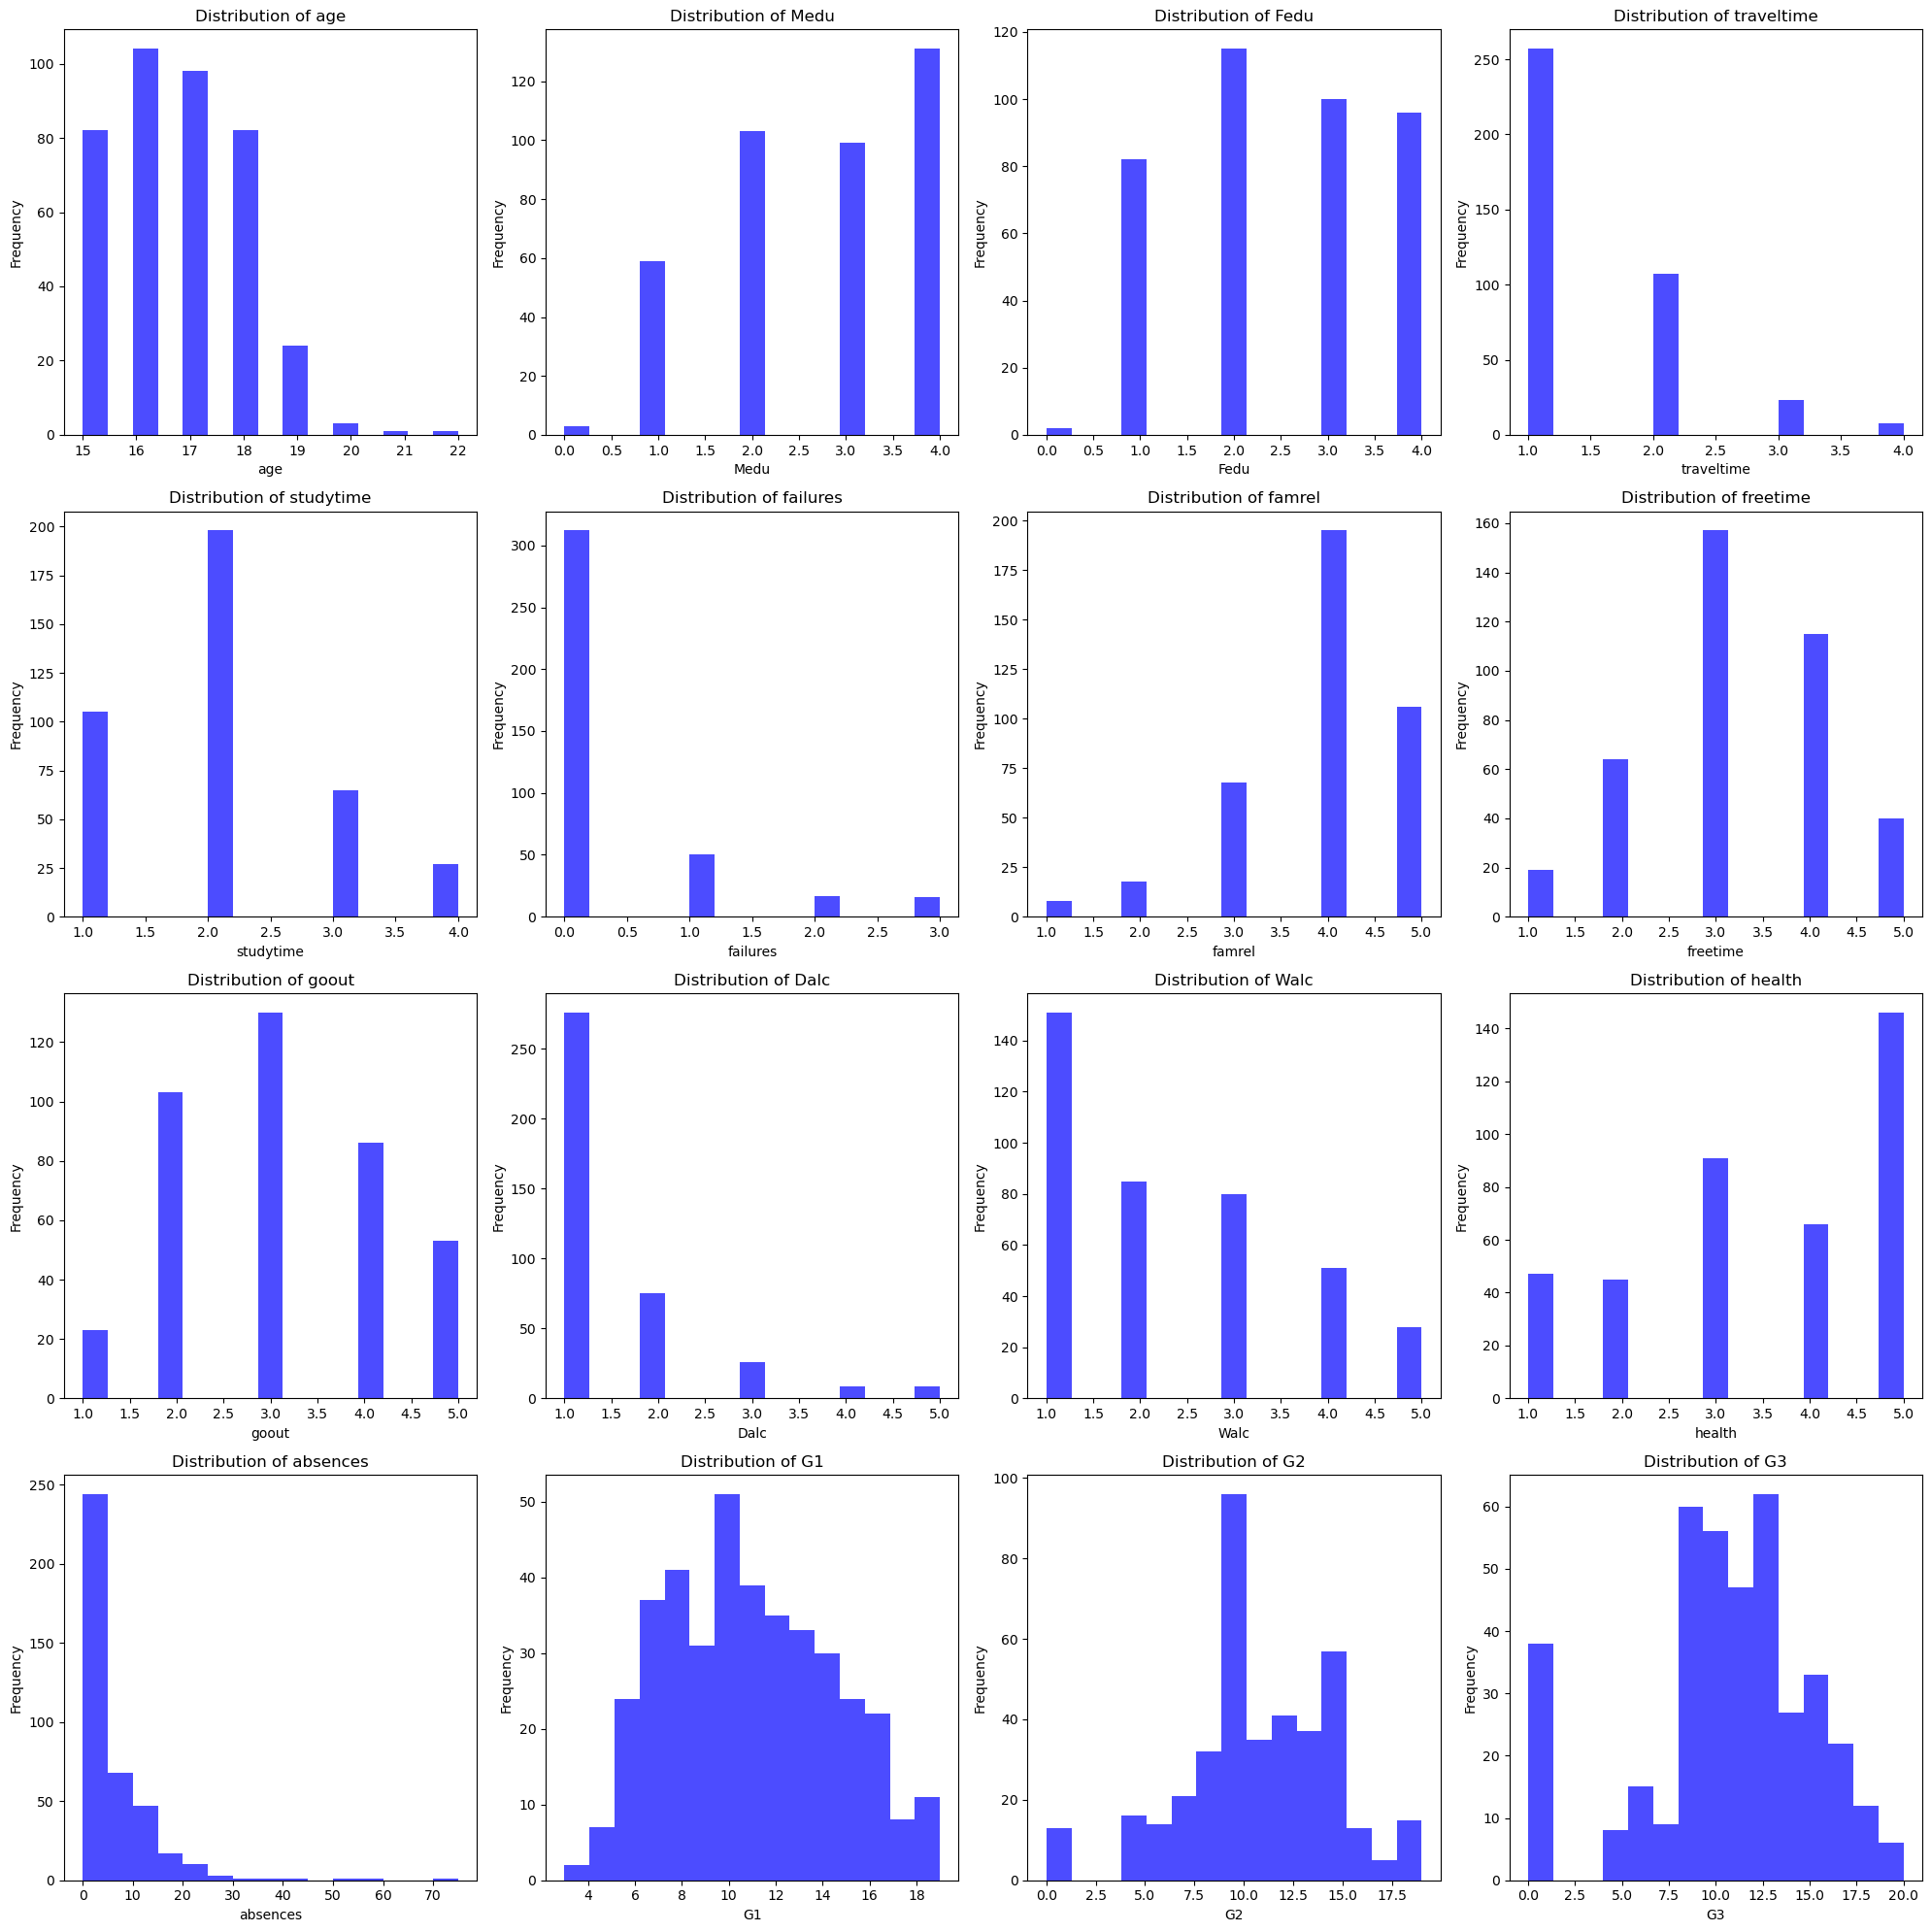

C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\3194099338.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\3194099338.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\3194099338.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\3194099338.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\3194099338.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.in

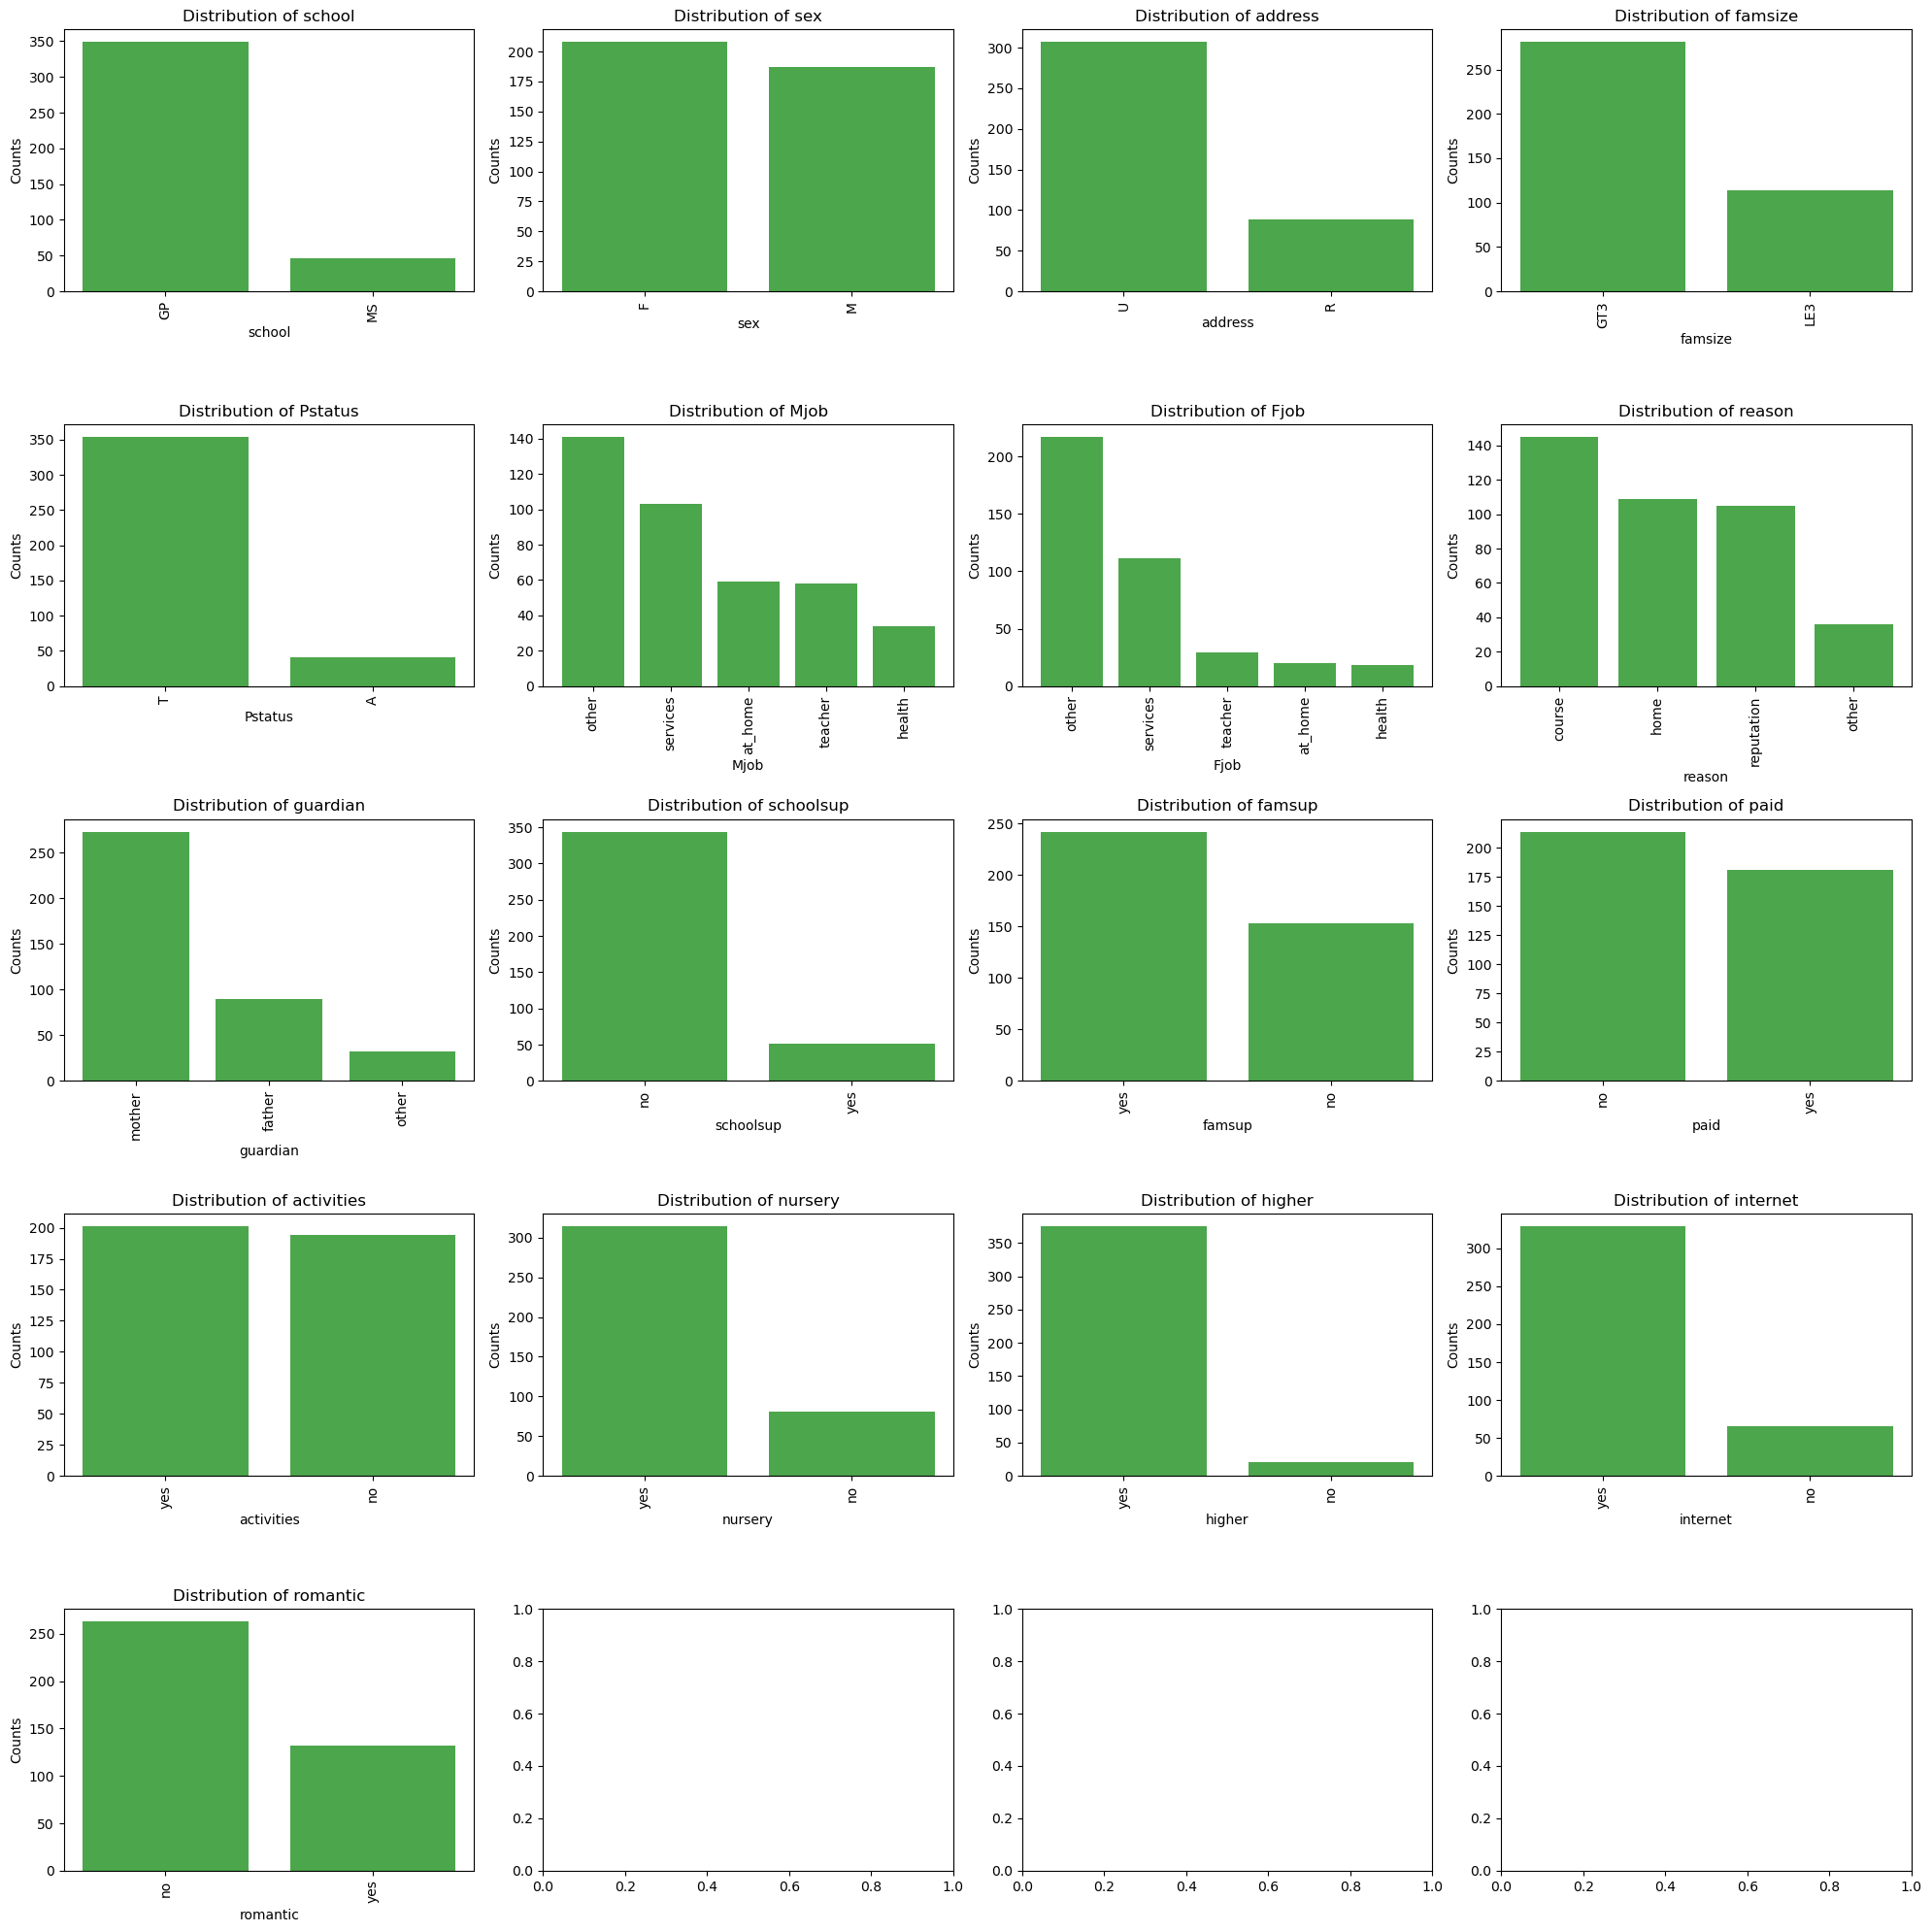

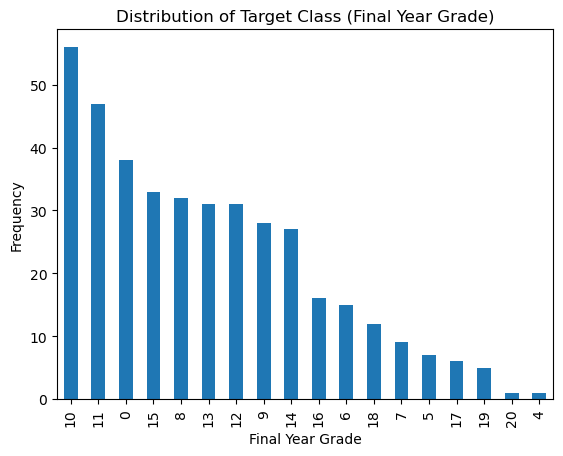

In [2]:
student_math = pd.read_csv("C:/Users/ramosv/Desktop/GitHub/Removing-Bias-from-ML-Models/students/student-mat.csv", delimiter=';', quotechar='"')

# Lets predifine the numerical and categorical variables since the data from the csv file does not come labeled
numerical_variables = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences", "G1", "G2", "G3"]

categorical_variables = ["school", "sex", "address", "famsize", "Pstatus", "Mjob","Fjob", "reason", "guardian", "schoolsup", "famsup","paid", "activities", "nursery", "higher", "internet","romantic"]

# I like to always start by exploring the distribution of the data to better understand
figures, axes = plt.subplots(4, 4, figsize=(20, 20))

for axis, var in zip(axes.flatten(), numerical_variables):
    axis.hist(student_math[var], bins=15, color="blue", alpha=0.7)
    axis.set_title(f"Distribution of {var}")
    axis.set_xlabel(var)
    axis.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# We do the same for the categorical variables
figures, axes = plt.subplots(5, 4, figsize=(20, 20))

for column in categorical_variables:
    student_math[column] = student_math[f"{column}"].astype("category")

for axis, var in zip(axes.flatten(), categorical_variables):
    counts = student_math[var].value_counts().sort_values(ascending=False)
    axis.bar(counts.index.astype(str), counts.values, color='green', alpha=0.7)
    axis.set_title(f'Distribution of {var}')
    axis.set_xlabel(var)
    axis.set_ylabel('Counts')
    axis.set_xticklabels(counts.index.astype(str), rotation=90)

plt.tight_layout()
plt.show()

# FInally the target class
student_math['G3'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Class (Final Year Grade)')
plt.xlabel('Final Year Grade')
plt.ylabel('Frequency')
plt.show()

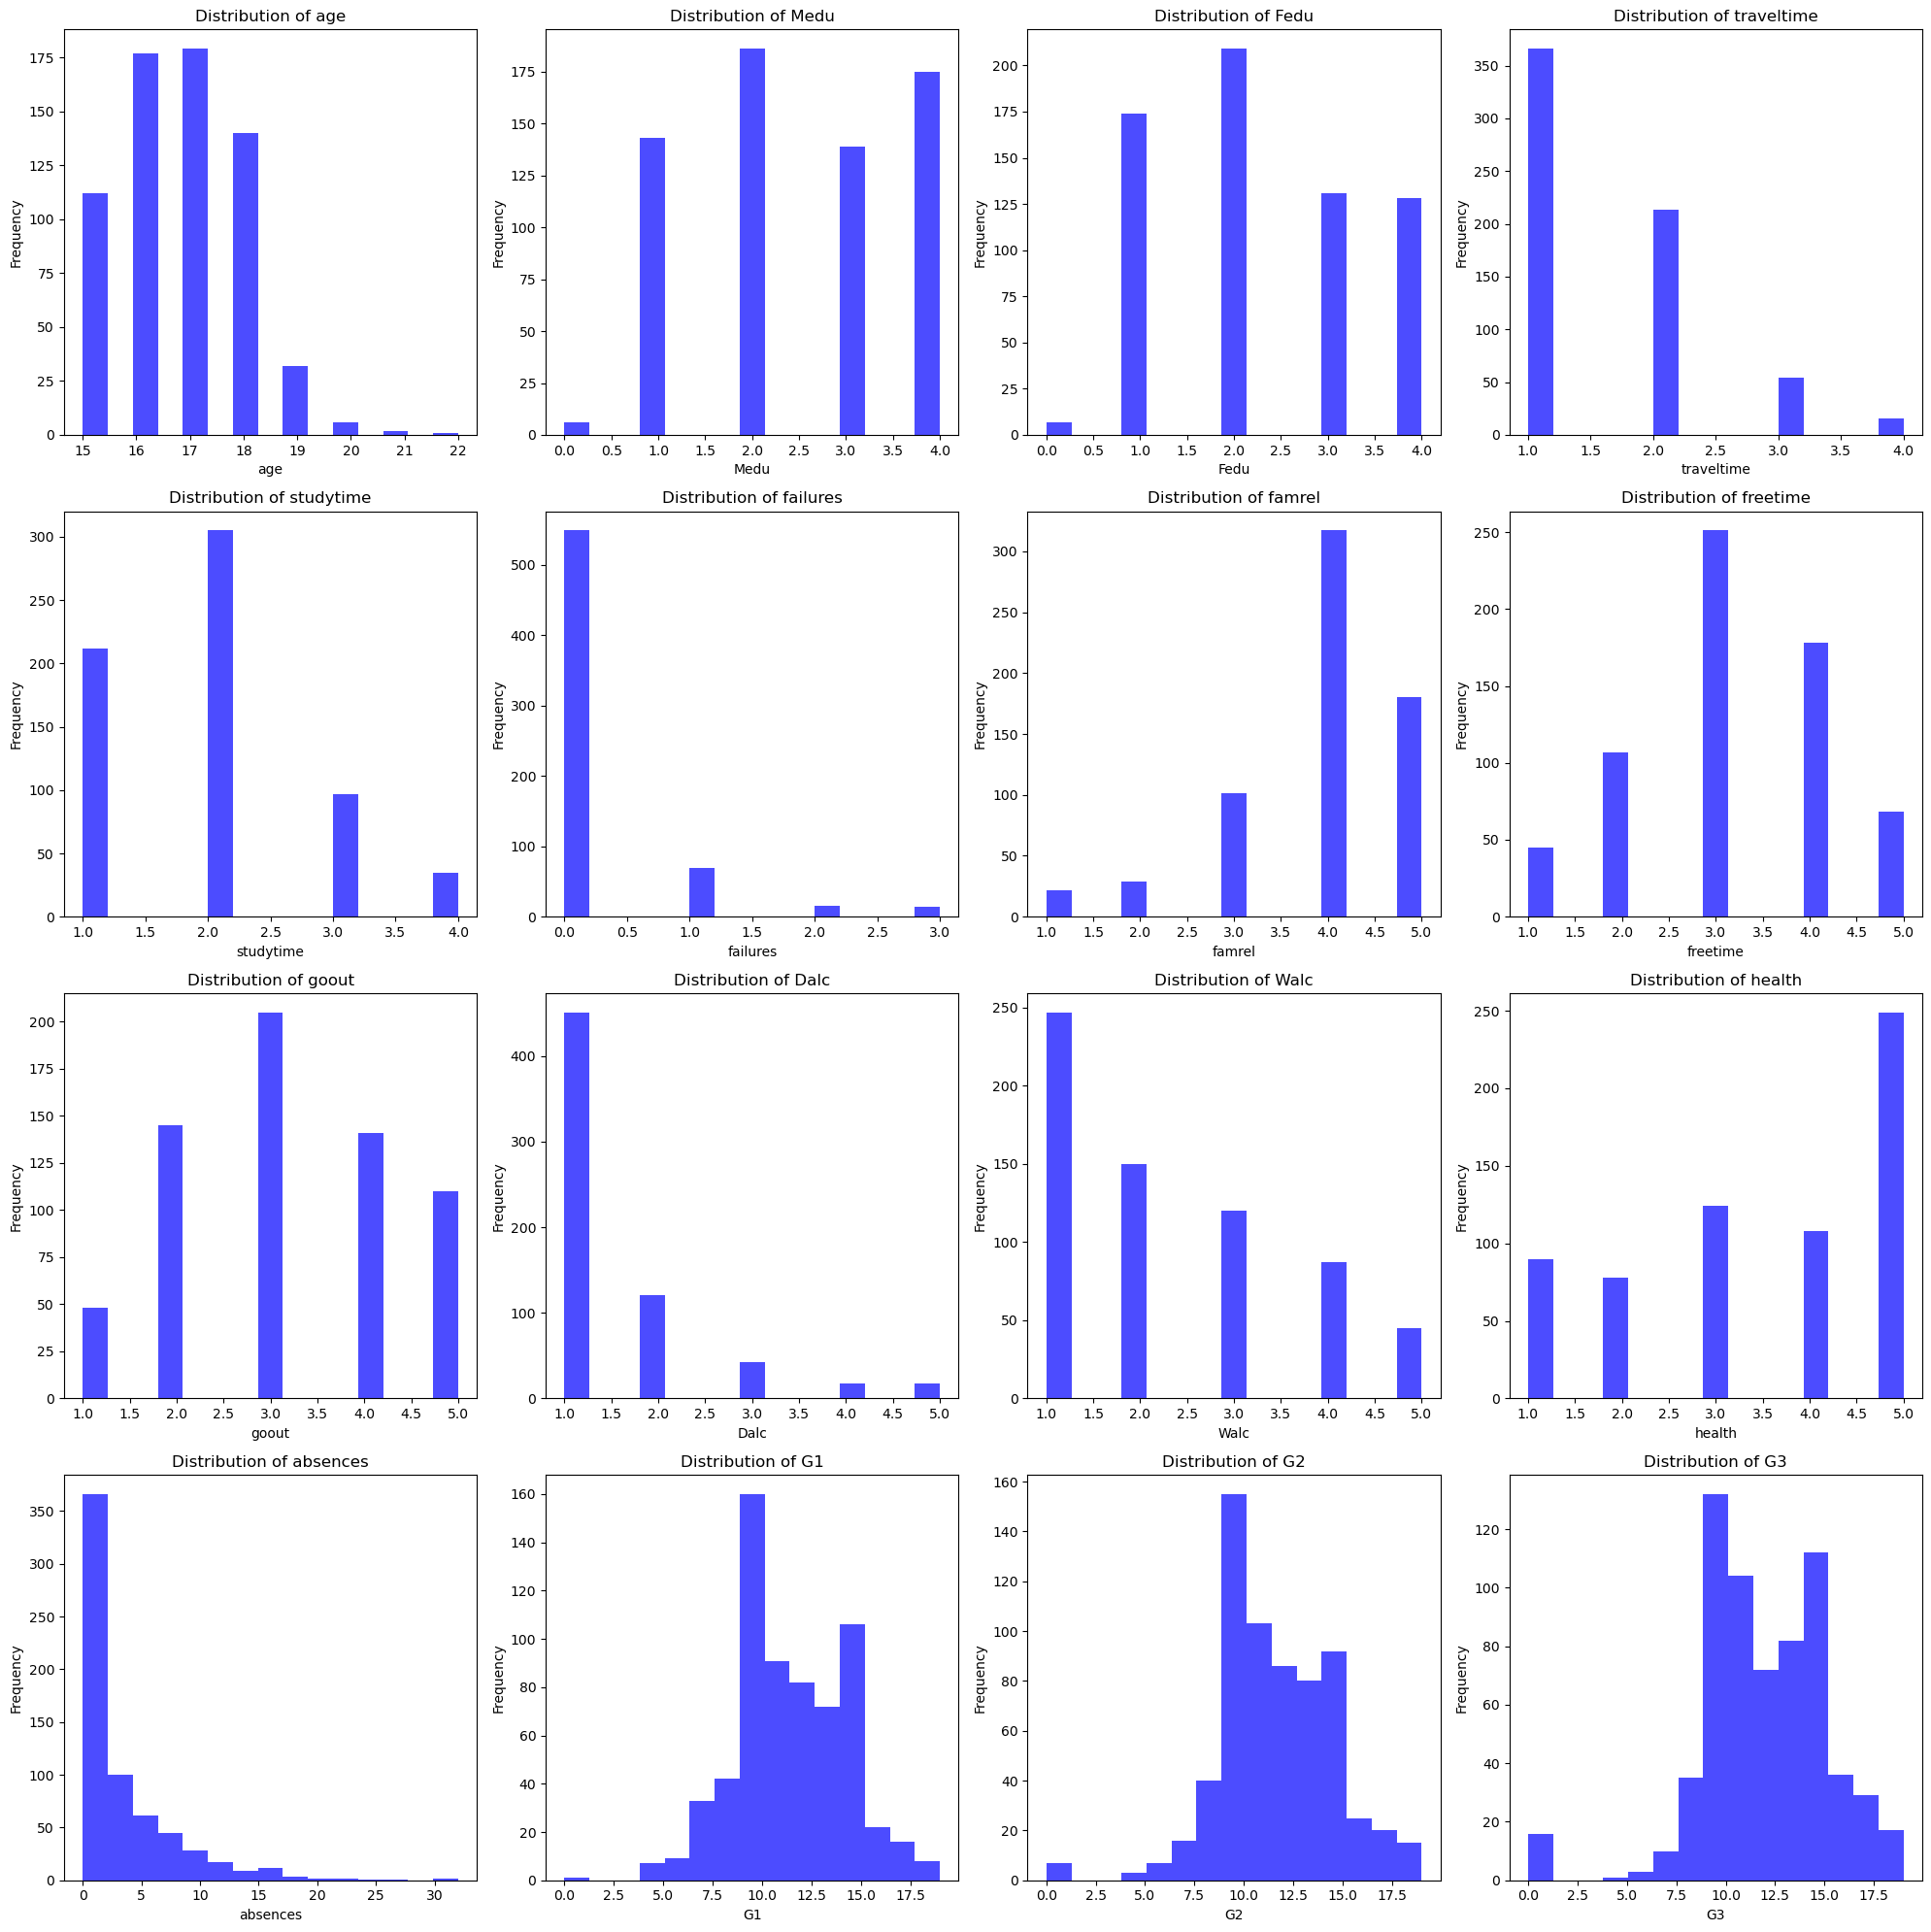

C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\1773228699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\1773228699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\1773228699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\1773228699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.index.astype(str), rotation=90)
C:\Users\ramosv\AppData\Local\Temp\ipykernel_25328\1773228699.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(counts.in

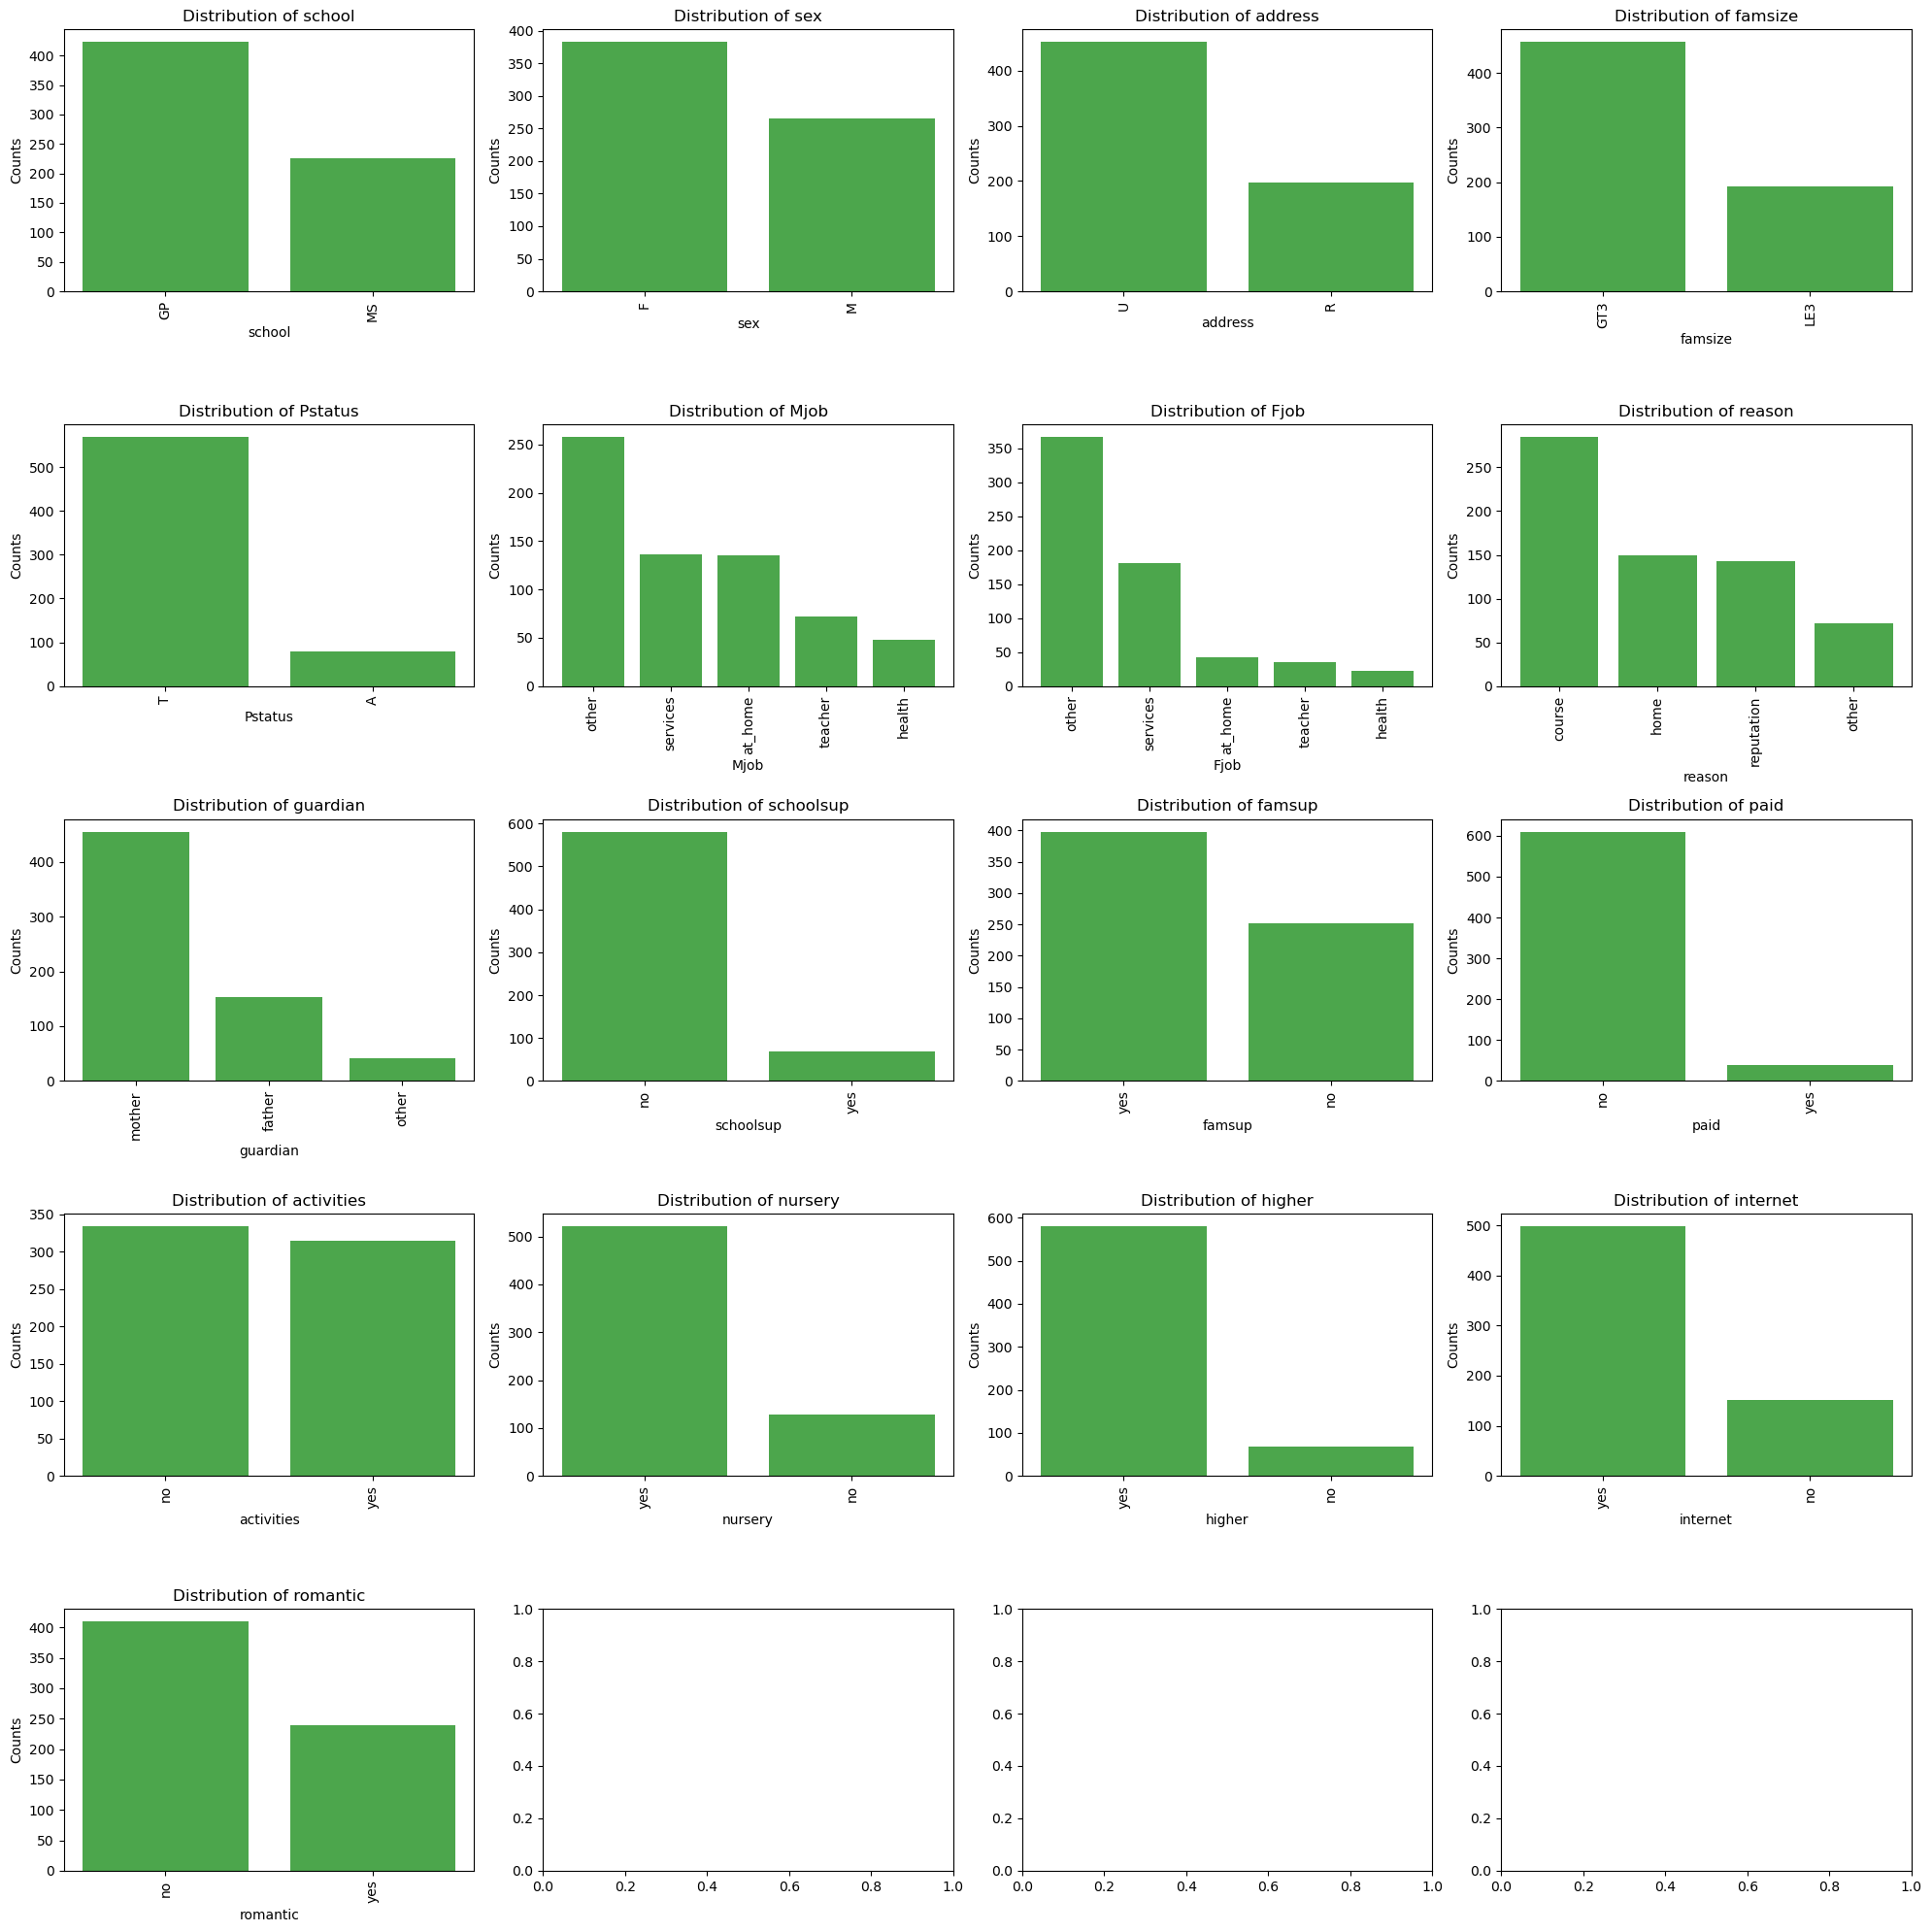

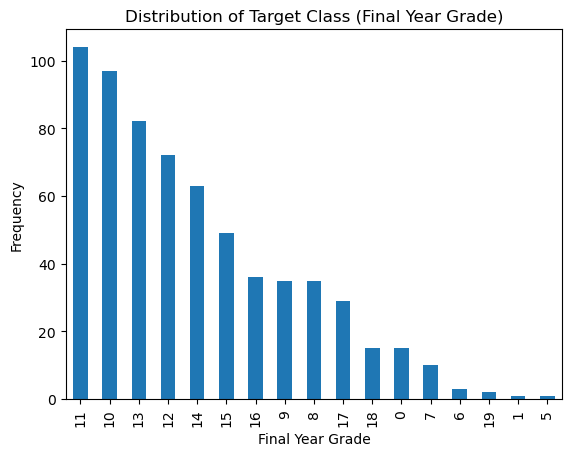

In [3]:
# THen we do the same thing for the second dataset which is basically the same featues but for a differnet class
student_portuguese = pd.read_csv("C:/Users/ramosv/Desktop/GitHub/Removing-Bias-from-ML-Models/students/student-por.csv", delimiter=';', quotechar='"')

numerical_variables = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures","famrel", "freetime", "goout", "Dalc", "Walc", "health","absences", "G1", "G2", "G3"]

categorical_variables = ["school", "sex", "address", "famsize", "Pstatus", "Mjob","Fjob", "reason", "guardian", "schoolsup", "famsup","paid", "activities", "nursery", "higher", "internet","romantic"]

# Ill reuse the code from the previous cell to plot the and numerical variables
figures, axes = plt.subplots(4, 4, figsize=(20, 20))

for axis, var in zip(axes.flatten(), numerical_variables):
    axis.hist(student_portuguese[var], bins=15, color="blue", alpha=0.7)
    axis.set_title(f"Distribution of {var}")
    axis.set_xlabel(var)
    axis.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

figures, axes = plt.subplots(5, 4, figsize=(20, 20))

for column in categorical_variables:
    student_portuguese[column] = student_portuguese[f"{column}"].astype("category")

for axis, var in zip(axes.flatten(), categorical_variables):
    counts = student_portuguese[var].value_counts().sort_values(ascending=False)
    axis.bar(counts.index.astype(str), counts.values, color='green', alpha=0.7)
    axis.set_title(f'Distribution of {var}')
    axis.set_xlabel(var)
    axis.set_ylabel('Counts')
    axis.set_xticklabels(counts.index.astype(str), rotation=90)

plt.tight_layout()
plt.show()

# Finally we take a look at the target class
student_portuguese['G3'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Class (Final Year Grade)')
plt.xlabel('Final Year Grade')
plt.ylabel('Frequency')
plt.show()

After graphing and exploring the data. I notice that they have the exactly same features with simimilar overall distrubution across each feature.

I am inclined to combine both datasets under one dataframe so that the model has more data to learn from.

In [12]:
# Now we will combine the two datasets but first we need to add a column to each dataset to identify the subject
student_math['subject'] = 'Math'
student_portuguese['subject'] = 'Portuguese'

# Using a range to create a unique student id for each student
student_math['student_id'] = range(1, len(student_math) + 1)
student_portuguese['student_id'] = range(len(student_math) + 1, len(student_math) + len(student_portuguese) + 1)

# FInally we combine the two datasets
combined_students = pd.concat([student_math, student_portuguese], ignore_index=True)

# Once combined we can encode the categorical variables using one hot encoding or get_dummies in pandas
combined_students_encoded = pd.get_dummies(combined_students, drop_first=True)

# defening the target and features with x and y
X = combined_students_encoded.drop(['G3', 'student_id'], axis=1)
y = combined_students_encoded['G3']

# Split then train the model using random forest regressor since we are predicting a continous variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# veriable to store the predictions
y_pred = model.predict(X_test)

# FInally we can calculate the metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')


RMSE: 1.6358289530499097
MSE: 2.675936363636364
MAE: 0.9367942583732057
R-squared: 0.8269214262657254


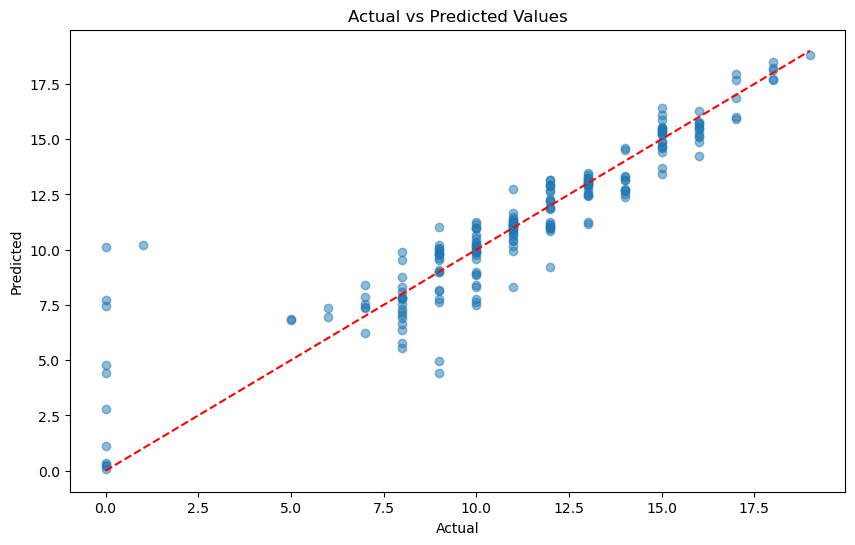

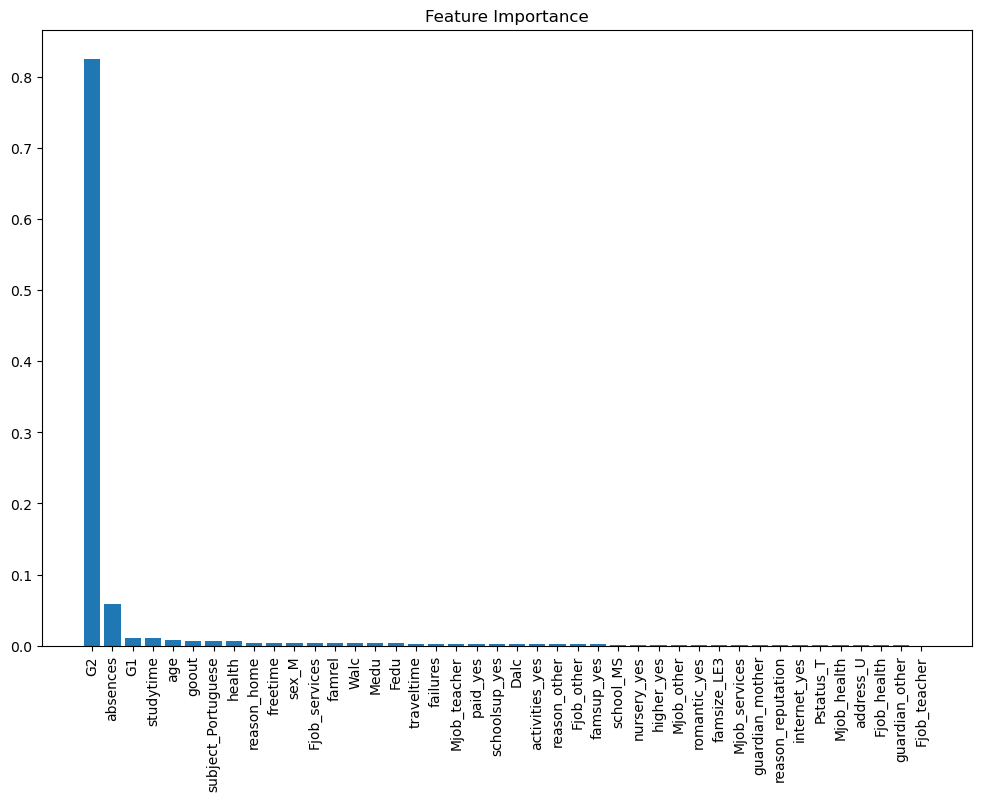

In [17]:

# Ill also plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

# Followed by the feature importance and a graph to visualize it
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()


Lets review the findings from the model performance and feature importance.

Root mean square error or RMSE is the square root of the mean differeneces between the prediciton made by the model and the actual value. A value of 1.64 tells us that on AVERAGE, the predictions made by the model deviate by -+1.64 from the actual grade.

Mean squared error or MSE is the mean of the squared differences between the prediciton made and the actual value. A value of 2.68 is quite low but not perfect. This is still a good indication that the model is performing well.

Mean absolute error or MAE is another average value which takes the absolute differnece between prediction and actual value. A value of 0.94 is very good value, it tells us that the model predictions are off by less than 1 grade. YES!

R-Squared is an interesting one, it is a measurement of how the model explains the variance in the target class, in this instace the final grade for each student. This will always be a value between 0 and 1. Since we got 0.83, this means that 83% of the variance in the final grade can be explained by the model. Which again is another great result.


Actual vs predictic graph:
The way to look at this graph is that we want the scatter plot values to be as close to the red dottet line. From the plot we see a very strong correlation between the scatter values and the prediction made by the model. There are certainly a few outlier specially for the lower grades. I will be investigation this issue, my guess is that the vast majority of the students did not get extremly low grades so the model struggles to learn from these students features.


Now that we trained a baseline model we can proceed with removing the bias
the assumtpion is that students that are older than >= 17 will perform better becuase they are more mature.

For the target class the favorable outcome would be any grade larger than 80% or in this case a value of 14 or larger

In [31]:
# Encode categorical variables
encoder = LabelEncoder()
for column in combined_students.select_dtypes(include=['object', 'category']).columns:
    combined_students[column] = encoder.fit_transform(combined_students[column])

def age_binary(age):
    if age >= 17:
        return 1
    else:
        return 0

# Define the target and protected attribute
combined_students['age_binary'] = combined_students['age'].apply(age_binary)

def target_binary(target):
    if target >= 16:
        return 1
    else:
        return 0

combined_students['G3_binary'] = combined_students['G3'].apply(target_binary)

# Convert to StandardDataset
dataset = StandardDataset(combined_students,
                          label_name='G3_binary',
                          favorable_classes=[1],
                          protected_attribute_names=['age_binary'],
                          privileged_classes=[[1]])

# Define privileged and unprivileged groups
privileged_groups = [{'age_binary': 1}]
unprivileged_groups = [{'age_binary': 0}]

# Calculate SPD and DI
metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

spd = metric.statistical_parity_difference()
di = metric.disparate_impact()

print(f'Statistical Parity Difference (SPD): {spd}')
print(f'Disparate Impact (DI): {di}')

Statistical Parity Difference (SPD): -0.013549162889649427
Disparate Impact (DI): 0.8898646616541354



A negative value for SPD tells us there is a slight bias against the privileged group or older students, but the difference is minimal.

A DI value of 0.8899 indicates that older students are slightly less likely to receive favorable outcomes compared to younger students

My goal from this point is to produce more samples for the ages 20, 21 and 22 since they are severy underrepsented. ("Saw this in the graphs")

We are gping to train a new model implementing sampling technique

In [36]:

# We can combine the original two datasets ainto a masive dataset and then resample the underrepresented ages
combined_students_sampling = pd.concat([student_math, student_portuguese], ignore_index=True)

# Encode categorical variables so that they can be used in the model
encoder = LabelEncoder()
for column in combined_students_sampling.select_dtypes(include=['object', 'category']).columns:
    combined_students_sampling[column] = encoder.fit_transform(combined_students_sampling[column])

# then we split the data into features and labels
X = combined_students_sampling.drop(columns=['G3', 'student_id'])
y = combined_students_sampling['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For resampling we will use the resample function from sklearn after combining the training data
# Also we separate data for ages 20, 21, and 22
train_data = pd.concat([X_train, y_train], axis=1)
underrepresented_ages = train_data[train_data['age'].isin([20, 21, 22])]

# Now to upsampling the underrepresented ages we can use resample from sklearn adding 60 samples to each age
upsampled_ages = resample(underrepresented_ages, replace=True, n_samples=60)

# Now we can finally combined the upsampled ages with the rest of the data
remaining_train_data = train_data[~train_data['age'].isin([20, 21, 22])]
upsampled_train_data = pd.concat([remaining_train_data, upsampled_ages])

# Split the data into features and labels once again
# THen we train the model using this data
X_train_upsampled = upsampled_train_data.drop(columns=['G3'])
y_train_upsampled = upsampled_train_data['G3']
model_upsampled = RandomForestRegressor(n_estimators=100, random_state=42)
model_upsampled.fit(X_train_upsampled, y_train_upsampled)

y_pred_upsampled = model_upsampled.predict(X_test)

# Calculate the metrics so we can then compare with the baseline model
rmse_upsampled = mean_squared_error(y_test, y_pred_upsampled, squared=False)
mse_upsampled = mean_squared_error(y_test, y_pred_upsampled)
mae_upsampled = mean_absolute_error(y_test, y_pred_upsampled)
r2_upsampled = r2_score(y_test, y_pred_upsampled)

print(f'RMSE (upsampled): {rmse_upsampled}')
print(f'MSE (upsampled): {mse_upsampled}')
print(f'MAE (upsampled): {mae_upsampled}')
print(f'R-squared (upsampled): {r2_upsampled}')


RMSE (upsampled): 1.712886285144849
MSE (upsampled): 2.933979425837321
MAE (upsampled): 0.9664593301435407
R-squared (upsampled): 0.8102312964948234


In [37]:
# NOw to do the bias mitigation once more with the upsampled data

# First to encode categorical variables we can use label encoder
encoder = LabelEncoder()
for column in combined_students_sampling.select_dtypes(include=['object', 'category']).columns:
    combined_students_sampling[column] = encoder.fit_transform(combined_students_sampling[column])

# Function to categorize columns into binary
def age_binary(age):
    if age >= 17:
        return 1
    else:
        return 0

def target_binary(target):
    if target >= 16:
        return 1
    else:
        return 0

combined_students_sampling['age_binary'] = combined_students_sampling['age'].apply(age_binary)
combined_students_sampling['G3_binary'] = combined_students_sampling['G3'].apply(target_binary)

# now use the standard dataset to convert the data and define the privileged and unprivileged groups
dataset = StandardDataset(combined_students_sampling,
                          label_name='G3_binary',
                          favorable_classes=[1],
                          protected_attribute_names=['age_binary'],
                          privileged_classes=[[1]])

privileged_groups = [{'age_binary': 1}]
unprivileged_groups = [{'age_binary': 0}]

# FInaly for the mretrics we can calculate SPD and DI agian
metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
spd = metric.statistical_parity_difference()
di = metric.disparate_impact()

print(f'Statistical Parity Difference (SPD): {spd}')
print(f'Disparate Impact (DI): {di}')

Statistical Parity Difference (SPD): -0.013549162889649427
Disparate Impact (DI): 0.8898646616541354


In summary, the model peformed worst, and the bias did not improve for the privilaged or unprovilged group.

The resampling technique helped to improve the representation of underrepresented age groups (20, 21, and 22), but the impact on bias metrics was minimal. This indicates that while resampling can help address some aspects of bias, it may not be sufficient on its own.

C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ramosv\anaconda3\lib\site-packages\sklearn\base.py:

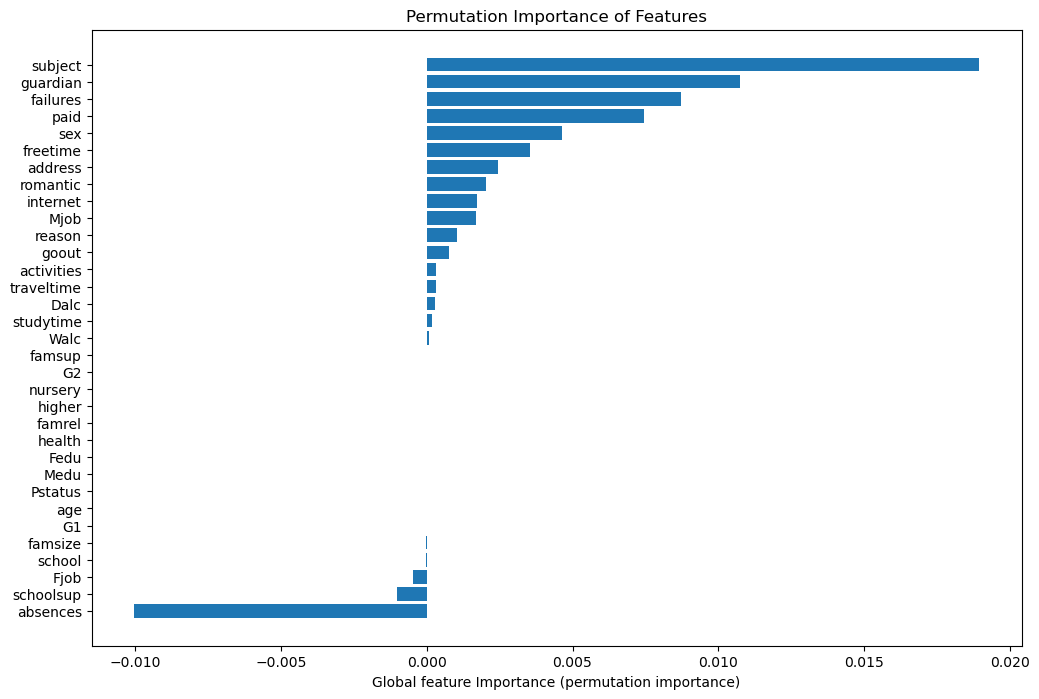

In [40]:
# For my last component I will be using LIME to explain the model prediciton and to compare how LIME and feature importance differ
# Code is very similar to what i used in assignemnt 1 but I had to make some changes to fit the new data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

# Creating an explainer object as defined in the lime_tabular documentation
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X_train.columns.tolist(),
    class_names=['Fail(0)', 'Pass(1)'],
    mode='regression'
)

# Select a single instance from the test set (first one in this example)
exp = explainer.explain_instance(X_test_scaled[0], model_upsampled.predict, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

# Calculating permutation importance for the global features
perm_importance = permutation_importance(model_upsampled, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Now to visualize the global importance of features
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(12, 8))
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Global feature Importance (permutation importance)')
plt.title('Permutation Importance of Features')
plt.show()

### Closing thoughts

Top Features from lime
interpretability

Comparison with previous values for feature importance
When we using model.feature_importance_ the feature importances extracted from the trained model. This measures the importance of each feature in comarasion to other feautures in the model.

In contrasts LIME shows permutation importance, which measures the change in the model performance when the features are randomly shuffled

So in summary LIME can provide a more accurate measure of a feature impact on the model predictions. Specillay since the model prediction will decreease if a cerstain feature is not being used.